In [1]:
import pandas as pd
from wordcloud import WordCloud as cloud
import matplotlib.pyplot as plt
import string
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS as stopwords
import nltk
nltk.download("wordnet")
nltk.download("stopwords")
from nltk.stem import WordNetLemmatizer as lemm, SnowballStemmer as stemm
from nltk.stem.porter import *
from nltk.corpus import stopwords
import en_core_web_lg
nlp =  en_core_web_lg.load()
import numpy as np
np.random.seed(0)
from gensim import corpora, models
from gensim.models import CoherenceModel
from pprint import pprint
import pyLDAvis as pyldavis
from pymongo import MongoClient


stop_words = stopwords.words('english')

# stop_words.extend(['reuters','cnbc','monday','tuesday','wednesday','thursday','friday','saturday','sunday',
#                    'year','inflation','week','price','russia','ukraine','datum', 'market','investor','interest','risk','rate',
#                    'stock','london', 'yesterday','since','today','level','policy','equity','trading','concern','pandemic','trade',
#                    'coronavirus','economy','month','range','time','day','calendar', 'central','bank','currency','pair','resistance',
#                    'government','rally', 'bear','bull','hike','move','gain','loss','rise','support','recovery','pressure','sentiment',
#                    'growth','trader','covid','crissis','asset','demand','number','wave','expectation',
#                    'index','session','meeting','high','trend','consumer','forecast','morning','break',
#                    'fear','sanction','cause','future','minute','stimulus','low','earning','reversal',
#                    'chart','channel','hour','monetary','dept','crisis', 'quarter','focus', 'target',
#                    'energy','report','yield','analyst','fund','dept','end','sell','bond','plunge',
#                    'january','february','march','april','may','june','july','august','september','october','november','december'])


connection=MongoClient("mongodb://localhost:27017/crawler.contents")

db=connection.get_database()

[nltk_data] Downloading package wordnet to /home/visnja/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/visnja/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/home/visnja/anaconda3/envs/python3.7-env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import re
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[trigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN','PROPN']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


def clean(txt):
    res = " ".join(txt)
    res = re.sub(r'[,\.!?]','',txt) 
    res = str(res.lower())
    res = re.sub(r'\d* min read', '', str(res), flags=re.IGNORECASE)
    res = re.sub(r'by reuters staff', '', str(res), flags=re.IGNORECASE)
    res = re.sub(r'reuters', '', str(res), flags=re.IGNORECASE)
    res = re.sub(r'australian dollar', 'aud', str(res), flags=re.IGNORECASE)
    res = re.sub(r'new zealand dollar', 'nzd', str(res), flags=re.IGNORECASE)
    res = re.sub(r'us dollar', 'usd', str(res), flags=re.IGNORECASE)
    res = re.sub(r'/', ' ', str(res), flags=re.IGNORECASE)
    res = re.sub(r'british pound', 'gbp', str(res), flags=re.IGNORECASE)
    res = re.sub(r'japanese yen', 'jpy', str(res), flags=re.IGNORECASE)
    res = re.sub(r'yen', 'jpy', str(res), flags=re.IGNORECASE)
    res = re.sub(r'britain', 'uk', str(res), flags=re.IGNORECASE)
    res = re.sub(r'british currency', 'gbp', str(res), flags=re.IGNORECASE)
    res = re.sub(r'british', 'uk', str(res), flags=re.IGNORECASE)
    res = re.sub(r'pound', 'gbp', str(res), flags=re.IGNORECASE)
    res = re.sub(r'sterling', 'gbp', str(res), flags=re.IGNORECASE)
    res = re.sub(r'united kingdom', 'uk', str(res), flags=re.IGNORECASE)
    res = re.sub(r'united states of america', 'usa', str(res), flags=re.IGNORECASE)
    res = re.sub(r'united states', 'usa', str(res), flags=re.IGNORECASE)
    res = re.sub(r'swiss franc', 'chf', str(res), flags=re.IGNORECASE)
    res = re.sub(r'new york', 'ny', str(res), flags=re.IGNORECASE)
    res = re.sub(r'canadian dollar', 'cad', str(res), flags=re.IGNORECASE)
    res = re.sub(r'europian central bank', 'ecb', str(res), flags=re.IGNORECASE)
    res = re.sub(r'chinese yuan', 'cny', str(res), flags=re.IGNORECASE)
    res = re.sub(r'yuan', 'cny', str(res), flags=re.IGNORECASE)
    res = re.sub(r'asia pacific', 'apac', str(res), flags=re.IGNORECASE)
    res = re.sub(r'european union', 'eu', str(res), flags=re.IGNORECASE)
    res = re.sub(r'turkish lira', 'try', str(res), flags=re.IGNORECASE)
    res = re.sub(r'turkey lira', 'try', str(res), flags=re.IGNORECASE)
    res = re.sub(r'russian ruble', 'rub', str(res), flags=re.IGNORECASE)
    res = re.sub(r'ruble', 'rub', str(res), flags=re.IGNORECASE)
    res = re.sub(r'rouble', 'rub', str(res), flags=re.IGNORECASE)
    res = re.sub(r'federal reserve', 'fed', str(res), flags=re.IGNORECASE)
    res = re.sub(r'hang seng index', 'hsi', str(res), flags=re.IGNORECASE)
    res = re.sub(r'international monetary fund', 'imf', str(res), flags=re.IGNORECASE)
    res = re.sub(r'euro ', 'eur ', str(res), flags=re.IGNORECASE)
    res = re.sub(r'foreign exchange', 'forex', str(res), flags=re.IGNORECASE)
    res = re.sub(r'england', 'uk', str(res), flags=re.IGNORECASE)
    return res

def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [3]:

articles = pd.DataFrame(list(db.contents.find()))
articles = articles.drop(columns=['visited','created_at','contentType','date','icon','_id'])
articles.head()
articles = articles.dropna(how='any',axis=0)

articles['text_processed_join'] = articles['summary'].map(lambda x: clean(x))



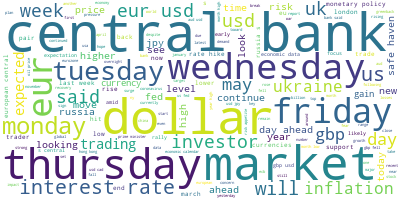

In [4]:
long_string = ','.join(list(articles['text_processed_join'].values))
wordcloud = cloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [5]:
data = articles['text_processed_join'].values.tolist()
data_words = list(sent_to_words(data))
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# remove stop words
data_words = remove_stopwords(data_words)

# Define functions for stopwords, bigrams, trigrams and lemmatization

data_words_nostops = data_words

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
data_word_trigrams = make_trigrams(data_words_bigrams)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams)
data_lemmatized = [[word for word in doc if word not in stop_words] for doc in data_lemmatized]

In [6]:
import gensim.corpora as corpora
import gensim.models as models

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]


In [7]:
from pprint import pprint

# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)
tfidf_lda_model = gensim.models.LdaMulticore(corpus=corpus_tfidf,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

# Print the Keyword in the 10 topics
pprint(tfidf_lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.033*"hike" + 0.024*"canada" + 0.020*"trend" + 0.020*"correction" + '
  '0.013*"wave" + 0.013*"break" + 0.013*"rate" + 0.012*"pattern" + '
  '0.011*"morning" + 0.011*"powell"'),
 (1,
  '0.079*"day" + 0.049*"target" + 0.041*"market" + 0.023*"sujata_rao" + '
  '0.019*"julien_ponthu" + 0.016*"pip" + 0.015*"test" + 0.014*"danilo_masoni" '
  '+ 0.014*"payment" + 0.013*"barrier"'),
 (2,
  '0.046*"usd" + 0.031*"eur" + 0.028*"level" + 0.027*"pair" + '
  '0.026*"resistance" + 0.026*"support" + 0.023*"jpy" + 0.023*"range" + '
  '0.018*"trading" + 0.016*"nzd"'),
 (3,
  '0.024*"calendar" + 0.021*"day" + 0.020*"decision" + 0.017*"today" + '
  '0.017*"datum" + 0.016*"bear" + 0.015*"stat" + 0.014*"ecb" + 0.013*"data" + '
  '0.013*"policy"'),
 (4,
  '0.018*"bank" + 0.016*"russia" + 0.012*"ukraine" + 0.011*"london" + '
  '0.009*"market" + 0.009*"japan" + 0.008*"wednesday" + 0.008*"economy" + '
  '0.008*"central" + 0.008*"crisis"'),
 (5,
  '0.014*"asia" + 0.014*"july" + 0.013*"exchange" + 0.013

In [8]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
import os

pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/02ldavis_prepared_'+str(num_topics))
LDAvis_prepared = pyLDAvis.gensim_models.prepare(tfidf_lda_model, corpus, id2word)


from gensim.models import CoherenceModel# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

LDAvis_prepared

/home/visnja/anaconda3/envs/python3.7-env/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)



Coherence Score:  0.34418627452754075


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.260256 -0.034886       1        1  31.892559
4      0.174653 -0.157151       2        1  19.596290
2      0.102261  0.282083       3        1  13.257797
3      0.074538 -0.039526       4        1   7.983102
0      0.030421  0.022976       5        1   5.776263
6      0.027346  0.007091       6        1   5.736755
5     -0.135508 -0.119599       7        1   4.742960
9     -0.174420  0.054808       8        1   3.863880
8     -0.198391 -0.014523       9        1   3.664876
1     -0.161155 -0.001273      10        1   3.485519, topic_info=                  Term         Freq        Total Category  logprob  loglift
104                day   956.000000   956.000000  Default  30.0000  30.0000
3               market  1112.000000  1112.000000  Default  29.0000  29.0000
7                  usd  1267.000000  1267.000000  Default  28.0000  28.0000
1246              pair   411.000000   411.000000  Default  27.0000  27.0000
1215        resistance   394.000000   394.000000  Default  26.0000  26.0000
...                ...          ...          ...      ...      ...      ...
345               lack    23.508558    26.225688  Topic10  -5.1448   3.2472
3443  sydney_australia    21.974511    24.691761  Topic10  -5.2123   3.2400
88                lift    20.943802    23.660999  Topic10  -5.2603   3.2346
104                day   317.426435   956.240449  Topic10  -2.5419   2.2538
3               market   164.953905  1112.171982  Topic10  -3.1965   1.4481

[506 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2036      1  0.985418  alun_john
1343      3  0.950092   analysis
1228      2  0.957510       apac
531       1  0.971209     appeal
2202      9  0.973246        apr
...     ...       ...        ...
1245      3  0.787431  yesterday
1245      4  0.085028  yesterday
1245      7  0.025878  yesterday
1245     10  0.025878  yesterday
3016      7  0.916637     zurich

[772 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 3, 4, 1, 7, 6, 10, 9, 2])

In [9]:
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)


In [10]:
 pyLDAvis.save_html(LDAvis_prepared, './results/02ldavis_prepared_'+ str(num_topics) +'.html')

In [11]:
# import numpy as np
# import tqdm

# grid = {}
# grid['Validation_Set'] = {}

# # Topics range
# min_topics = 2
# max_topics = 11
# step_size = 1
# topics_range = range(min_topics, max_topics, step_size)

# # Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')

# # Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')

# # Validation sets
# num_of_docs = len(corpus)
# corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
#                corpus]

# corpus_title = ['75% Corpus', '100% Corpus']

# model_results = {'Validation_Set': [],
#                  'Topics': [],
#                  'Alpha': [],
#                  'Beta': [],
#                  'Coherence': []
#                 }

# # Can take a long time to run
# if 1 == 1:
#     pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
#     # iterate through validation corpuses
#     for i in range(len(corpus_sets)):
#         # iterate through number of topics
#         for k in topics_range:
#             # iterate through alpha values
#             for a in alpha:
#                 # iterare through beta values
#                 for b in beta:
#                     # get the coherence score for the given parameters
#                     cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
#                                                   k=k, a=a, b=b)
#                     # Save the model results
#                     model_results['Validation_Set'].append(corpus_title[i])
#                     model_results['Topics'].append(k)
#                     model_results['Alpha'].append(a)
#                     model_results['Beta'].append(b)
#                     model_results['Coherence'].append(cv)
                    
#                     pbar.update(1)
#     pd.DataFrame(model_results).to_csv('./results/lda_tuning_results.csv', index=False)
#     pbar.close()

In [12]:
first = id2word.doc2bow(texts[0])

In [13]:


for index, score in sorted(lda_model[first][0], key=lambda tup: -1*tup[1]):
    print("\nIndex: {}\nScore: {}\t \nTopic: {}".format(index,score, tfidf_lda_model.print_topic(index, 10)))

print(texts[0])


Index: 7
Score: 0.9181649088859558	 
Topic: 0.023*"dollar" + 0.017*"currency" + 0.016*"coronavirus" + 0.014*"investor" + 0.014*"market" + 0.013*"week" + 0.012*"gbp" + 0.012*"rate" + 0.011*"year" + 0.011*"wednesday"
['currency', 'usd', 'monday', 'plunge', 'year', 'end', 'week', 'sell', 'bond', 'market']


/home/visnja/anaconda3/envs/python3.7-env/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/visnja/anaconda3/envs/python3.7-env/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/visnja/anaconda3/envs/python3.7-env/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/visnja/anaconda3/envs/python3.7-env/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
